# Setup
## Setup matplotlib to perform inline plots

In [1]:
%matplotlib inline

## Import the required modules

In [2]:
from matplotlib.ticker import MultipleLocator
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
import numpy as np

# Functions for working with signals
## WAV file I/O

In [3]:
def wav2file(fname, data, sr):
    """
    Write wave data to file `fname`.
    Sample rate is `sr`.
    """
    #Write it to a file.
    wf.write(fname, sr, data.astype(np.int16))

## Plot signals

In [39]:
def plot_wav(sig, sr=16000, unit_time=False, **kwds):
    """
    Function for quickly plotting a WAV signal.
    Returns the time series used to plot the signal.
    """
    num_samples = len(sig)
    start = 0
    if unit_time:
        stop = 1.0
    else:
        stop = float(num_samples) / float(sr)
    t = np.linspace(start, stop, num=num_samples)
    
    figsize = kwds.get('figsize', None)
    if figsize is None:
        figsize = (float(stop)/3.5*17.0, 5.5)
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.plot(t, sig)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    return t

def move_legend(ax=None, rpad=0):
    """
    Move the legend outside the data area of the axes.
    """
    if ax is None:
        ax = gca()
    ax.legend(loc="center left", bbox_to_anchor=(1+rpad, 0.5))

def center_ylims(ax):
    """
    Set the Y-axis limits so the data is centered vertically.
    """
    l, u = ax.get_ylim()
    b = max(abs(l), u)
    ax.set_ylim(-b, b)
    
def draw_vlines(ax, xcoords, color='k', linestyle='--', linewidth=1):
    """
    Draw a series of vertical lines.
    """
    for x in xcoords:
        ax.axvline(x, color=color, linestyle=linestyle, linewidth=linewidth)
        
def draw_tangent(ax, x,y,a, pointcolor='m', linecolor='r'):
    """
    Plot the line tangent to data series (x, y) at X-position `a`.
    """
    # interpolate the data with a spline
    spl = interpolate.splrep(x,y)
    small_t = arange(a-5,a+5)
    fa = interpolate.splev(a,spl,der=0)     # f(a)
    fprime = interpolate.splev(a,spl,der=1) # f'(a)
    tan = fa+fprime*(small_t-a) # tangent
    ax.plot(a,fa,'o'+pointcolor)
    ax.plot(small_t, tan, '--' + linecolor, label='tangent at %0.3f' % a)


## Signal processing functions

In [5]:
def norm_series(s, max_magnitude=None):
    if max_magnitude is None:
        max_magnitude = max(abs(s.max()), abs(s.min()))
    return s.astype(np.float64) / np.float64(max_magnitude)

def abs_series(s):
    """
    Make series `s` poisitive by inverting any negative values.
    """
    return np.abs(s)

def signal_to_freq_domain(signal, sr):
    """
    Take the Fourier Transform of a signal.
    """
    #Take the Fourier Transform of the signal.
    sp = np.fft.fft(signal)
    #Get frequencies.
    freqs = np.fft.fftfreq(signal.shape[-1], d=(1.0 / sr))
    #Get the total number of samples in the signal.
    n = len(signal)
    #Only take the positive half of the frequencies and signals.
    freqs = freqs[:int(n / 2)]
    signal = sp.real[:int(n / 2)]
    signal = np.abs(signal)
    return (signal, freqs)

def compute_tangent_slope(x, y, a):
    """
    Return the slope of the line tangent to the data series (x, y) at
    X position `a`.
    """
    spl = interpolate.splrep(x,y)
    small_t = arange(a-5,a+5)
    fa = interpolate.splev(a,spl,der=0)     # f(a)
    fprime = interpolate.splev(a,spl,der=1) # f'(a)
    tan = fa+fprime*(small_t-a) # tangent

    return (tan[0]-tan[1])/(small_t[0]-small_t[1])

def compute_tangent_slopes(x, series):
    """
    Return an array of slopes of lines tangent to (x, series) at each position in `x`.
    """
    tans = np.array([compute_tangent_slope(x, series, a) for a in x])
    return tans

# Analyze a Sound Wave
## Record a sound wave as a WAV file.
The following shell command, `sox`, starts recording when it detects sound on your microphone and stops recording when it detects silence.  The sound wave is recorded as 16 bit pulse code modulated data sampled at 44,100Hz over a single channel (mono).

In [43]:
%%bash

sox -c 1 -r 44100 -t alsa default ./wavs/recording.wav silence 1 0.1 5% 1 1.0 5%


Input File     : 'default' (alsa)
Channels       : 1
Sample Rate    : 44100
Precision      : 16-bit
Sample Encoding: 16-bit Signed Integer PCM

In:0.00% 00:00:03.72 [00:00:00.00] Out:7.26k [      |      ] Hd:0.0 Clip:0    
Done.


## Plot the signal in the time domain
The signal is normalized before plotting so that the amplitude falls between -1.0 and 1.0 (inclusive).

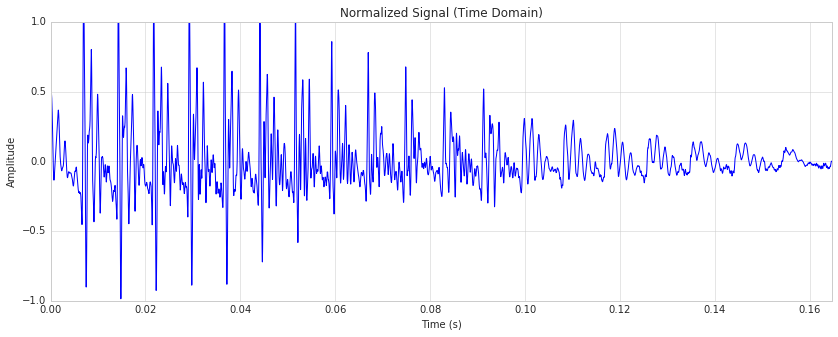

In [47]:
#filename = "./wavs/A4-440.wav"
#filename = "./wavs/middle-c.wav"
filename = "./wavs/recording.wav"
sr, signal = wf.read(filename)
signal_norm = norm_series(signal)
with plt.style.context(('seaborn-whitegrid')):
    x = plot_wav(signal_norm, sr, figsize=(14, 5))
    ax = plt.gca()
    rval = ax.set_xlim(0.0, x.max())
    center_ylims(ax)
    rval = plt.title("Normalized Signal (Time Domain)")

## Plot the signal in the frequency domain
By plotting the signal in the frequency domain by using a fast Fourier transform, we should quickly be able to determine the fundamental frequency of the signal.  We extract the maximum frequency (or frequencies) from the transformed signal.

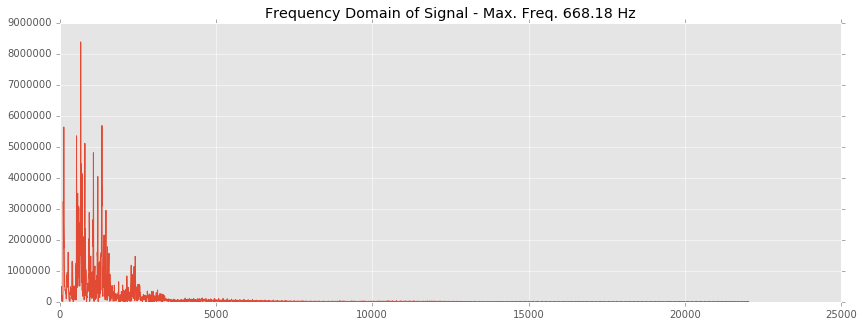

In [48]:
sr, signal = wf.read(filename)
freq_signal, freqs = signal_to_freq_domain(signal, sr)
with plt.style.context(('ggplot')):
    fig = plt.figure(figsize=(14, 5))
    ax = plt.gca()
    rval = ax.plot(freqs, freq_signal)
    max_freqs = freqs[freq_signal == freq_signal.max()]
    max_freq_str = ', '.join(['{0:.2f}'.format(r) for r in max_freqs])
    rval = plt.title("Frequency Domain of Signal - Max. Freq. {0} Hz".format(max_freq_str))